In [2]:
pip install -q --upgrade jcopdl==1.1.10 # set_config hanya bisa digunakan pada versi jcopdl ini

Note: you may need to restart the kernel to use updated packages.


In [23]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Dataset & Dataloader

In [24]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [25]:
BATCH_SIZE = 128
IMG_DIR = '/kaggle/input/neural-network-dataset/data/'

transform = transforms.Compose([
    transforms.Grayscale(), # convert ke hitam putih
    transforms.ToTensor() # convert ke tensor
]) # data pipeline

train_set = datasets.ImageFolder(IMG_DIR + 'train/', transform=transform)
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # 2 core cpu

test_set = datasets.ImageFolder(IMG_DIR + 'test/', transform=transform)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) # 2 core cpu

In [26]:
train_set

Dataset ImageFolder
    Number of datapoints: 40000
    Root location: /kaggle/input/neural-network-dataset/data/train/
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [27]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([128, 1, 28, 28])

In [28]:
label2cat = train_set.classes
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# Arsitektur & Config

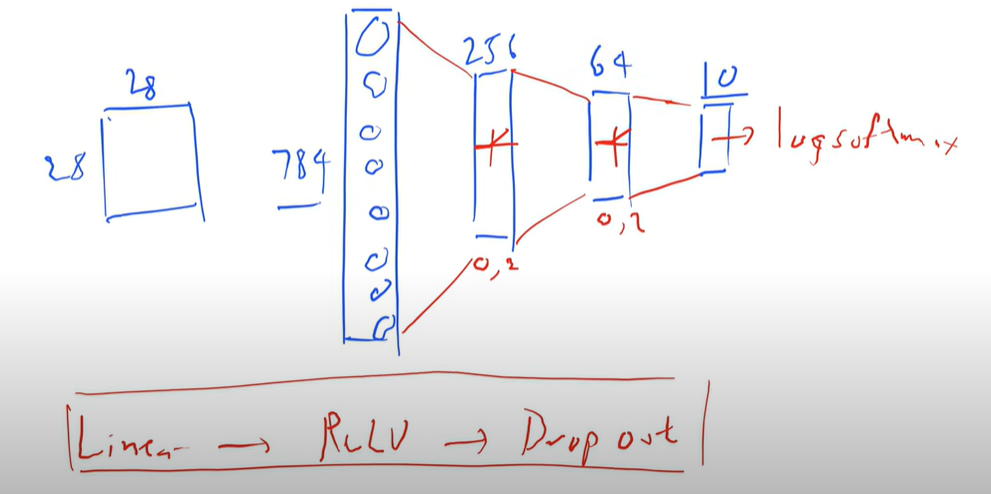

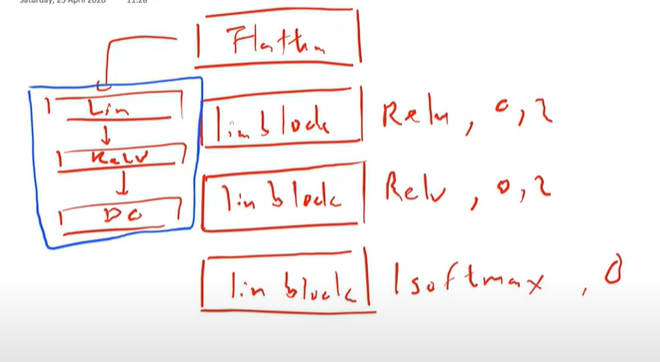

**linear_block** = `Linear` -> `Activation` -> `Dropout`

In [29]:
from jcopdl.layers import linear_block

In [30]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size, n1, n2, output_size, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, n1, dropout=dropout), # input harus 784 karena gambar 28x28 pixel
            linear_block(n1, n2, dropout=dropout),
            linear_block(n2, output_size, activation="lsoftmax"),
        )
        
    def forward(self, x):
        return self.fc(x)

In [31]:
config = set_config({
    "input_size": 784, # input harus 784 karena gambar 28x28 pixel
    "n1": 256,
    "n2": 64,
    "output_size": len(train_set.classes),
    "dropout": 0.2,
})

config

Config(dropout=0.2, input_size=784, n1=256, n2=64, output_size=10)

# Training Preparation -> MCOC

In [32]:
model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

# Training

In [33]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc

Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.7353 | Test_cost  = 0.4630 | Train_score = 0.7390 | Test_score = 0.8351 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.4717 | Test_cost  = 0.3995 | Train_score = 0.8328 | Test_score = 0.8527 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>

  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    self._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
AssertionError    : can only test a child process
if w.is_alive():Exception ig

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>
<function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: self._shutdown_workers(): can only test a child process

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLo


Epoch     3
Train_cost  = 0.4157 | Test_cost  = 0.3774 | Train_score = 0.8507 | Test_score = 0.8633 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.3898 | Test_cost  = 0.3759 | Train_score = 0.8612 | Test_score = 0.8616 |
==> EarlyStop patience =  1 | Best test_score: 0.8633


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.3679 | Test_cost  = 0.3479 | Train_score = 0.8688 | Test_score = 0.8720 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.3499 | Test_cost  = 0.3323 | Train_score = 0.8742 | Test_score = 0.8790 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.3352 | Test_cost  = 0.3276 | Train_score = 0.8799 | Test_score = 0.8802 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3278 | Test_cost  = 0.3238 | Train_score = 0.8827 | Test_score = 0.8791 |
==> EarlyStop patience =  1 | Best test_score: 0.8802


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>    
if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        assert self._parent_pid == os.getpid(), 'can only test a child process'
self._shutdown_workers()
AssertionError:   File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
can only test a child process
    if w.is_alive():Exception ig

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910><function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()if w.is_alive():Exception ignored in: 

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    Traceback (most recent call last):
    assert self._parent_p


Epoch     9
Train_cost  = 0.3193 | Test_cost  = 0.3272 | Train_score = 0.8839 | Test_score = 0.8784 |
==> EarlyStop patience =  2 | Best test_score: 0.8802


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3083 | Test_cost  = 0.3184 | Train_score = 0.8871 | Test_score = 0.8802 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3018 | Test_cost  = 0.3147 | Train_score = 0.8890 | Test_score = 0.8861 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.2951 | Test_cost  = 0.3150 | Train_score = 0.8925 | Test_score = 0.8851 |
==> EarlyStop patience =  1 | Best test_score: 0.8861


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.2909 | Test_cost  = 0.3092 | Train_score = 0.8936 | Test_score = 0.8891 |


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.2807 | Test_cost  = 0.3077 | Train_score = 0.8950 | Test_score = 0.8885 |
==> EarlyStop patience =  1 | Best test_score: 0.8891


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Traceback (most recent call last):
      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
if w.is_alive():    
self._shutdown_workers()  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/opt/conda/lib/python3.10/multiprocessing/process.

Test:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910><function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

Exception ignored in:     Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x792e587c3910>self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    
Traceback (most recent call last):
self._shutdown_workers()  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__

      File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
        self._shutdown_worke


Epoch    15
Train_cost  = 0.2753 | Test_cost  = 0.3111 | Train_score = 0.8981 | Test_score = 0.8876 |
==> EarlyStop patience =  2 | Best test_score: 0.8891


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.2691 | Test_cost  = 0.3170 | Train_score = 0.9015 | Test_score = 0.8847 |
==> EarlyStop patience =  3 | Best test_score: 0.8891


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.2620 | Test_cost  = 0.3107 | Train_score = 0.9038 | Test_score = 0.8870 |
==> EarlyStop patience =  4 | Best test_score: 0.8891


Train:   0%|          | 0/313 [00:00<?, ?it/s]

Test:   0%|          | 0/157 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.2595 | Test_cost  = 0.3158 | Train_score = 0.9039 | Test_score = 0.8882 |
==> EarlyStop patience =  5 | Best test_score: 0.8891
==> Execute Early Stopping at epoch: 18 | Best test_score: 0.8891
==> Best model is saved at model


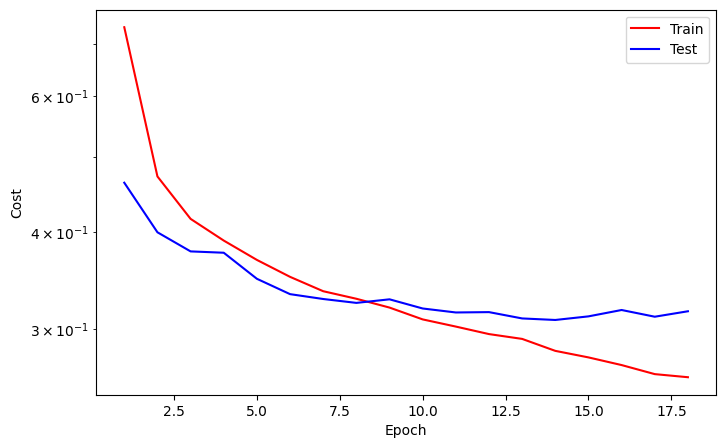

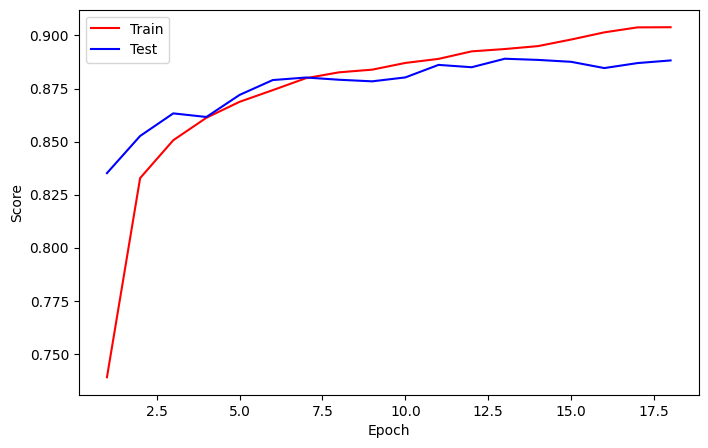

In [34]:
while True:
    train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)
        
    # Logging and Reporting
    callback.log(train_cost, test_cost, train_score, test_score)

    # Checkpoint
    callback.save_checkpoint() # menyimpan progress training setiap beberapa epoch

#     # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

    # Early Stopping
    if callback.early_stopping(model, monitor='test_score'): # akan menghentikan proses training(looping) berdasarkan test_score sehingga tanpa menentukan jumlah epoch
        callback.plot_cost()
        callback.plot_score()
        break

# Early Stoping Concept

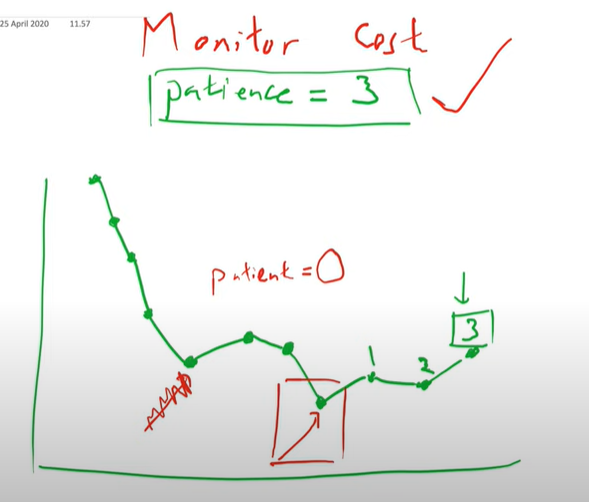

# Load Best Model

Karena `Early Stopping` melakukan save terhadapa `model/weight terbaik` maka kita tinggal load `model/weights terbaik`

In [43]:
weights = torch.load('/kaggle/working/model/weights_best.pth', map_location='cpu')
config = torch.load('/kaggle/working/model/configs.pth', map_location='cpu')

model = FashionClassifier(config.input_size, config.n1, config.n2, config.output_size, config.dropout)
model.load_state_dict(weights)
model = model.to(device)

# Predict

In [44]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [45]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([2, 0, 5, 0, 1, 7, 2, 9, 0, 8, 0, 0, 8, 8, 0, 3, 7, 9, 5, 7, 5, 9, 1, 4,
        3, 3, 1, 4, 9, 1, 2, 7, 4, 9, 6, 4, 8, 4, 7, 0, 0, 7, 7, 2, 1, 8, 8, 0,
        4, 8, 5, 5, 6, 8, 6, 9, 4, 3, 7, 2, 1, 7, 1, 2, 0, 5, 1, 9, 3, 4, 5, 5,
        0, 3, 0, 7, 8, 4, 0, 2, 4, 8, 7, 0, 1, 3, 7, 3, 1, 1, 6, 5, 6, 3, 9, 1,
        1, 6, 8, 5, 7, 1, 1, 9, 2, 0, 9, 1, 8, 0, 5, 9, 0, 2, 4, 3, 2, 2, 6, 5,
        2, 1, 3, 8, 8, 1, 5, 6], device='cuda:0')

In [46]:
label2cat

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

In [42]:
[label2cat[pred] for pred in preds]

['Bag',
 'Pullover',
 'Bag',
 'T-shirt or Top',
 'T-shirt or Top',
 'T-shirt or Top',
 'Sneaker',
 'Pullover',
 'Coat',
 'Pullover',
 'Dress',
 'Bag',
 'Pullover',
 'Pullover',
 'Sneaker',
 'Bag',
 'Coat',
 'T-shirt or Top',
 'T-shirt or Top',
 'T-shirt or Top',
 'Sneaker',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Dress',
 'Coat',
 'Sandal',
 'Sandal',
 'Coat',
 'Ankle boot',
 'T-shirt or Top',
 'Trouser',
 'Trouser',
 'Sandal',
 'Pullover',
 'Sandal',
 'Sneaker',
 'Ankle boot',
 'Trouser',
 'T-shirt or Top',
 'Dress',
 'Trouser',
 'Sandal',
 'Shirt',
 'Trouser',
 'Sandal',
 'Sneaker',
 'Sandal',
 'Shirt',
 'Pullover',
 'Sneaker',
 'Sneaker',
 'Ankle boot',
 'Coat',
 'Sneaker',
 'Coat',
 'Coat',
 'Shirt',
 'Bag',
 'Bag',
 'T-shirt or Top',
 'Dress',
 'Sneaker',
 'Pullover',
 'Dress',
 'Sneaker',
 'Shirt',
 'Dress',
 'Bag',
 'Shirt',
 'Ankle boot',
 'Ankle boot',
 'Sneaker',
 'Ankle boot',
 'Sandal',
 'Trouser',
 'T-shirt or Top',
 'Ankle boot',
 'Coat',
 'Sandal',
 'Sneaker',
 'Shirt

# Visualisasi

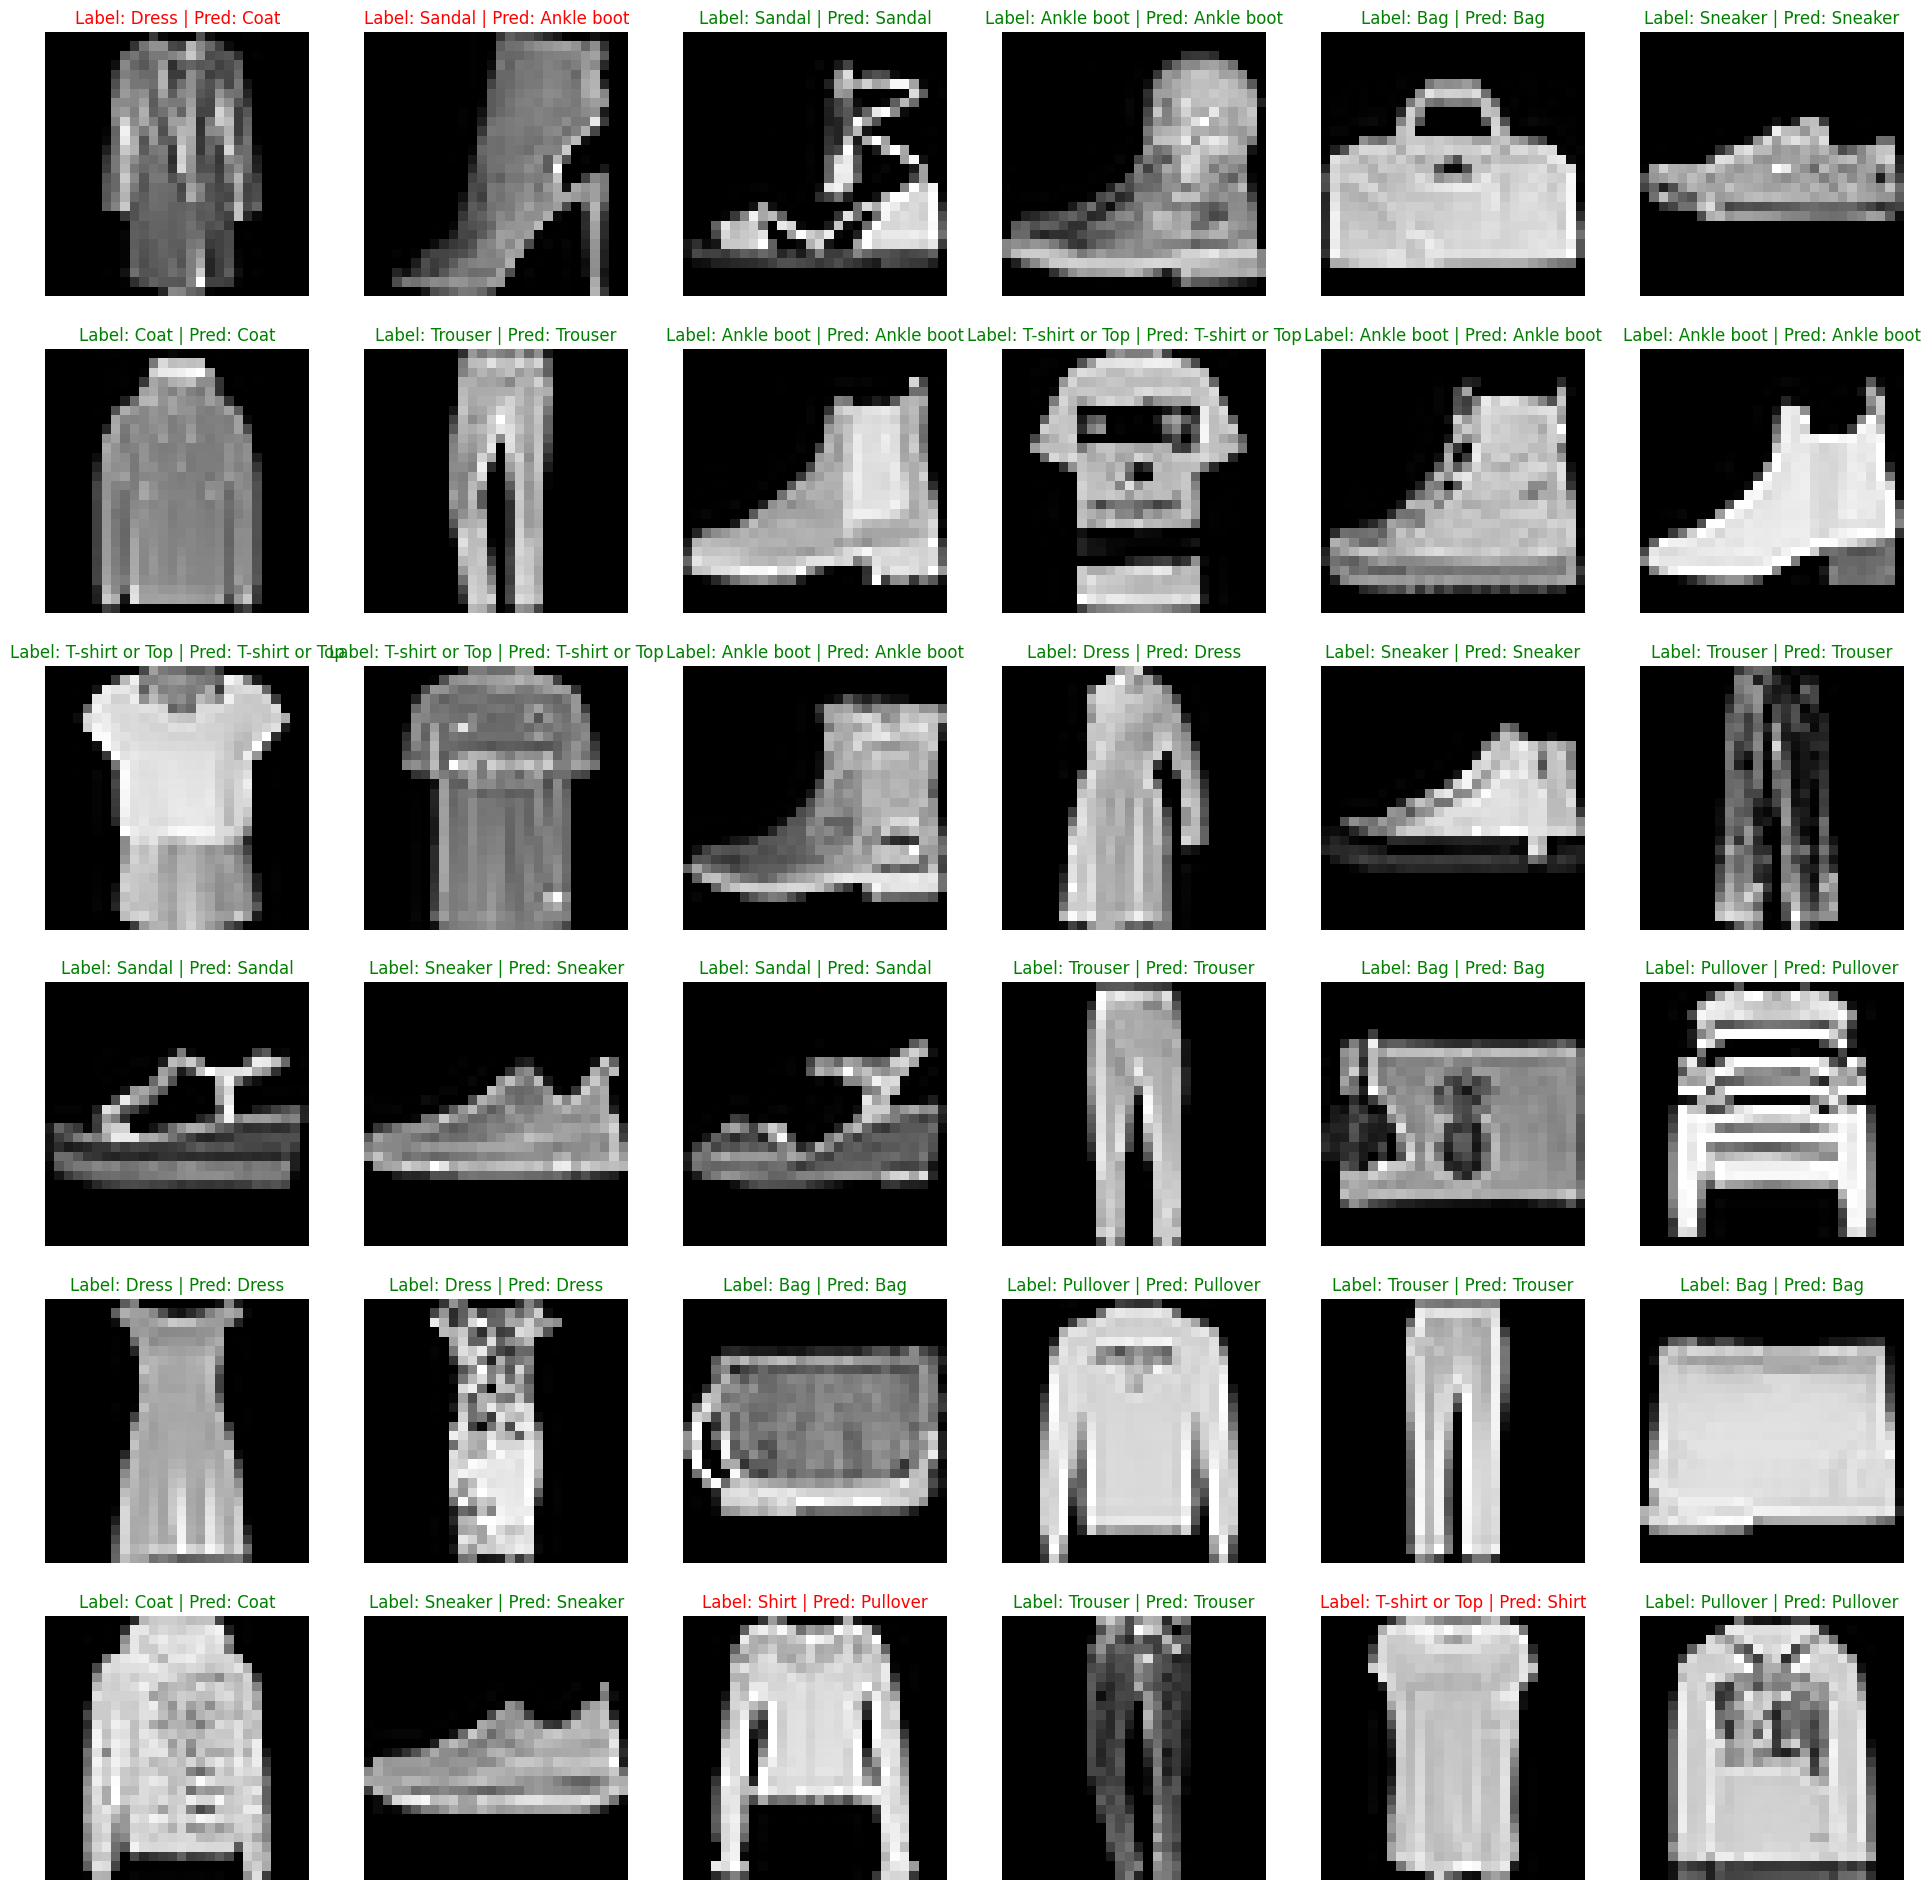

In [51]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(img.view(28, 28).cpu(), cmap='gray')
    font = {"color": "g"} if label == pred else {"color": "r"}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
    ax.axis('off');